In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## **Change into your folder**

In [ ]:
import os
os.chdir("/content/gdrive/MyDrive/fire_detector/") ###### change to your dir here

In [ ]:
import os
os.chdir("/content/gdrive/MyDrive/kaggle") #zoey's

In [ ]:
ls

fire_dataset/  fire-dataset.zip  kaggle.json  loss_curves.png  model.pt


In [ ]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Normalize
from torch.utils.data import DataLoader, random_split, Subset, WeightedRandomSampler
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.utils.data.dataset as dataset_utils

a
def is_orange(img):
    #img = Image.fromarray(img.astype(np.uint8))
    gray = np.array(img.convert('L'))
    orange_pixels = np.where(np.logical_and(gray >= 200, gray <= 255))
    return len(orange_pixels[0]) / (img.size[0] * img.size[1]) > 0.75

# class CustomTransform:
#     def __call__(self, img):
#         img = img.resize((224, 224))
#         if is_orange(img):
#             label = torch.tensor(1)
#         else:
#             label = torch.tensor(0)
#         img_tensor = transforms.ToTensor()(Image.fromarray(np.array(img)))
#         return img_tensor, label

class CustomTransform:
    def __call__(self, img):
        if is_orange(img):
            label = 0
        else:
            label = 1
        return img

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    CustomTransform(), ######
    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    CustomTransform(),
    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Load the dataset using ImageFolder
dataset = ImageFolder('fire_dataset')

# Split the dataset into training, validation and testing sets
dataset_size = len(dataset)
test_size = int(0.1 * dataset_size)
val_size = int(0.1 * dataset_size)
train_size = dataset_size - test_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Apply transforms to each dataset
train_data.dataset.transform = train_transforms
val_data.dataset.transform = val_transforms


# Define the data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

print("Number of images in train dataset:", len(train_loader))
print("Number of images in val dataset:", len(val_loader))

# Define the ResNet model architecture
model = torchvision.models.resnet18(pretrained=True) #double check here
num_features = model.fc.in_features
hidden_dim = 256
num_classes = 2

# ############### Add more hidden layers
# #add more hidden layers
# classifier = nn.Sequential(
#     nn.Linear(num_features, hidden_dim),
#     nn.ReLU(),
#     nn.Linear(hidden_dim, hidden_dim),
#     nn.ReLU(),
#     nn.Linear(hidden_dim, num_classes)
# )

# model.fc = classifier
# ########################

model.fc = nn.Linear(512, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# ################### freezing the convolutional layers and training only the fully connected layer #########
# # Freeze convo layers and fine-tune the fc layer
# for param in model.parameters():
#   param.requires_grad = False

# for param in model.fc.parameters():
#   param.requires_grad = True

# criterion = nn.CrossEntropyLoss()
# optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
# #######################


# # ######### Freeze convo layers and fine tune #########
# # freeze convo layers
# for param in model.parameters():
#   param.requires_grad = False
# # fine tune last convo block and fc layer
# for param in model.layer4.parameters():
#   param.requires_grad = True
# for param in model.fc.parameters():
#   param.requires_grad = False

# criterion = nn.CrossEntropyLoss()
# optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
# # ################



# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001) #fine tune the whole model
#instead of model.param => model.fc.parameters()

# Define the training loop
def train(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss /= len(train_loader)
    print("train_loss: {:.3f}".format(train_loss))
    print("total trained: {}".format(total))
    print("correct: {}".format(correct))
    return train_loss

# Define the validation loop
def validate(model, val_loader, criterion):
    model.eval()

    predictions = []
    targets = []
    with torch.no_grad():
        val_loss = 0
        val_acc = 0
        for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            predictions += predicted.tolist()
            targets += labels.tolist()
            val_acc += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc /= len(val_data)

    #f1_score calculation
    f1_scores = []
    thresholds = np.arange(0.1, 1.0, 0.1)
    for threshold in thresholds:
        tp, fp, fn = 0, 0, 0
        for i in range(len(predictions)):
            if predictions[i] == 1 and targets[i] == 1:
                tp += 1
            elif predictions[i] == 1 and targets[i] == 0:
                fp += 1
            elif predictions[i] == 0 and targets[i] == 1:
                fn += 1
        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * precision * recall / (precision + recall + 1e-10)
        f1_scores.append(f1)
    return val_loss, val_acc, f1_scores, thresholds



Number of images in train dataset: 26
Number of images in val dataset: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Train the model
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(10):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, f1_scores, thresholds = validate(model, val_loader, criterion)
    print("Epoch {}: Validation Loss = {:.3f}, Validation Accuracy = {:.3f}".format(epoch+1, val_loss, val_acc))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # for i in range(len(f1_scores)):
    #     print(f"F1 Score (Threshold {thresholds[i]:.1f}): {f1_scores[i]:.3f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "model.pt")


train_loss: 0.232
total trained: 801
correct: 748
Epoch 1: Validation Loss = 0.066, Validation Accuracy = 0.980
train_loss: 0.107
total trained: 801
correct: 769
Epoch 2: Validation Loss = 0.242, Validation Accuracy = 0.949
train_loss: 0.044
total trained: 801
correct: 792
Epoch 3: Validation Loss = 0.063, Validation Accuracy = 0.980
train_loss: 0.029
total trained: 801
correct: 792
Epoch 4: Validation Loss = 0.031, Validation Accuracy = 0.990
train_loss: 0.248
total trained: 801
correct: 795
Epoch 5: Validation Loss = 0.053, Validation Accuracy = 0.990
train_loss: 0.187
total trained: 801
correct: 757
Epoch 6: Validation Loss = 0.307, Validation Accuracy = 0.899
train_loss: 0.188
total trained: 801
correct: 757
Epoch 7: Validation Loss = 0.481, Validation Accuracy = 0.859
train_loss: 0.066
total trained: 801
correct: 781
Epoch 8: Validation Loss = 0.179, Validation Accuracy = 0.970
train_loss: 0.045
total trained: 801
correct: 784
Epoch 9: Validation Loss = 0.031, Validation Accuracy 

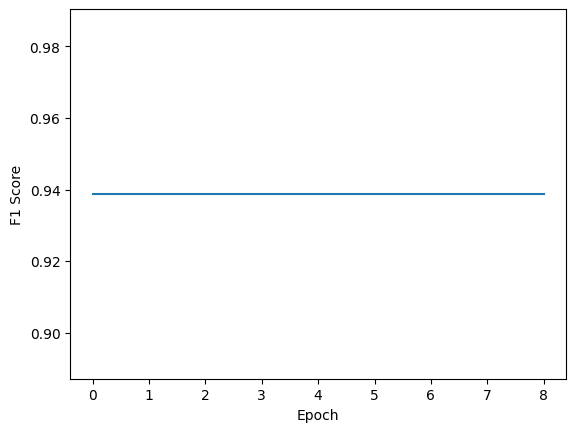

In [ ]:
plt.plot(range(0, 9), f1_scores)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.show()



In [ ]:
#print requires_grad:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.downsample.0.weight True
layer2.0.downsample.1.weight True
layer2.0.downsample.1.bias True
layer2.1.conv1.weight True
layer2.1.bn1.weight True
layer2.1.bn1.bias True
layer2.1.conv2.weight True
layer2.1.bn2.weight True
layer2.1.bn2.bias True
layer3.0.conv1.weight True
layer3.0.bn1.weight True
layer3.0.bn1.bias True
layer3.0.conv2.weight True
layer3.0.bn2.weight True
layer3.0.bn2.bias True
layer3.0.downsample.0.weight True
layer3.0.downsample.1.weight True
layer3.0.downsample.1.bias True
la

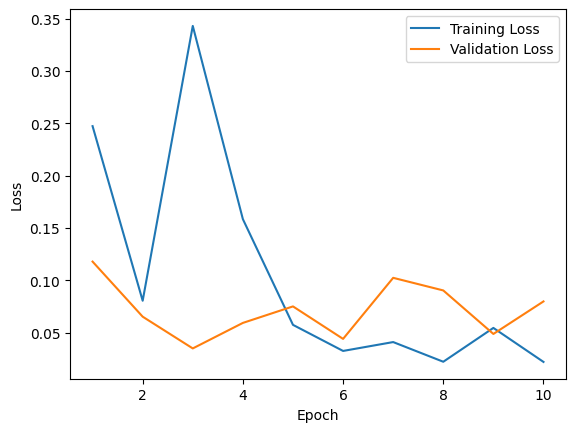

In [ ]:
# Plot the loss curves
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_curves.png')

################### fine tune all #########

In [ ]:
# Load the test data
test_data.dataset.transform = val_transforms
test_loader = DataLoader(test_data, batch_size=32)


# Evaluate the model on the test data
test_loss = 0
test_acc = 0
model.eval()


pos = 0
neg = 0
true_pos = 0
true_neg = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      test_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      test_acc += (predicted == labels).sum().item()
      pos += (labels == 1).sum().item()
      neg += (labels == 0).sum().item()
      true_pos += (labels * predicted == 1).sum().item()
      true_neg += (torch.logical_or(labels, predicted) == 0).sum().item()

    true_pos_rate = true_pos / pos
    false_pos_rate = (neg - true_neg)/neg
    test_loss /= len(test_loader)
    test_acc /= len(test_data)
print("true pos rate = {:.3f}".format(true_pos_rate))
print("false pos rate = {:.3f}".format(false_pos_rate))
print("true pos = {:.3f}".format(true_pos))
print("false pos = {:.3f}".format(true_neg))

print("Test Loss = {:.3f}, Test Accuracy = {:.3f}".format(test_loss, test_acc))

print(f"F1 Score (Threshold {thresholds[4]:.1f}): {f1_scores[4]:.3f}")


true pos rate = 0.957
false pos rate = 0.013
true pos = 22.000
false pos = 75.000
Test Loss = 0.096, Test Accuracy = 0.980
F1 Score (Threshold 0.5): 0.979


In [ ]:
for i, (inputs, labels) in enumerate(test_loader):
    if i == 0:
        for j in range(len(inputs)):
            image_idx = test_loader.dataset.indices[j]
            image_name = test_loader.dataset.dataset.samples[image_idx][0]
            print("Image: {} \nLabels: {}\n".format(image_name, labels[j]))


Image: fire_dataset/fire_images/fire.723.png 
Labels: 0

Image: fire_dataset/non_fire_images/non_fire.54.png 
Labels: 1

Image: fire_dataset/fire_images/fire.554.png 
Labels: 0

Image: fire_dataset/non_fire_images/non_fire.177.png 
Labels: 1

Image: fire_dataset/fire_images/fire.461.png 
Labels: 0

Image: fire_dataset/non_fire_images/non_fire.197.png 
Labels: 1

Image: fire_dataset/fire_images/fire.465.png 
Labels: 0

Image: fire_dataset/non_fire_images/non_fire.224.png 
Labels: 1

Image: fire_dataset/fire_images/fire.298.png 
Labels: 0

Image: fire_dataset/fire_images/fire.454.png 
Labels: 0

Image: fire_dataset/fire_images/fire.218.png 
Labels: 0

Image: fire_dataset/fire_images/fire.725.png 
Labels: 0

Image: fire_dataset/fire_images/fire.528.png 
Labels: 0

Image: fire_dataset/fire_images/fire.266.png 
Labels: 0

Image: fire_dataset/fire_images/fire.246.png 
Labels: 0

Image: fire_dataset/fire_images/fire.23.png 
Labels: 0

Image: fire_dataset/fire_images/fire.269.png 
Labels: 0

I

In [ ]:
from PIL import Image
from torchvision.transforms.functional import resize, to_tensor, normalize

def predict_image(image_path, model, threshold=0.3):
  image = Image.open(image_path)
  image = val_transforms(image)
  inputs = torch.unsqueeze(image, 0).to(device)
  outputs = model(inputs)
  _, predicted = torch.max(outputs, 1)
  probability = F.softmax(outputs, dim=1)[0][predicted]
  print(predicted)
  print(F.softmax(outputs, dim=1))
  print(outputs)

  if predicted == 1 and probability > threshold:
    print("Fire detected with probability {:.3f}".format(probability))
  else:
    print("No fire detected")

In [ ]:
# os.chdir("/content/gdrive/MyDrive/kaggle/fire_dataset/fire_images")


In [ ]:
cwd = os.getcwd()
print(cwd)

/content/gdrive/MyDrive/fire_detector


In [ ]:
# get the current working directory
current_dir = os.getcwd()

# specify the relative path to the image file
image_path = os.path.join(current_dir, "fire_dataset/fire_images/fire.210.png")


predict_image(image_path, model)